# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

In [0]:
from google.colab import drive
drive.mount('/content/drive')

### Import the necessary libraries

In [0]:
%tensorflow_version 2.x

import csv
import os
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback

### Change directory

In [0]:
project_path = '/content/drive/My Drive/Colab Notebooks/Lab/R9'

In [0]:
os.chdir(project_path)

In [5]:
# Check current working directory.
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/Lab/R9'

### Load the training data from train.csv file

In [0]:
train_labels_df = pd.read_csv('train_labels.csv')

### Print the shape of the train dataset

In [7]:
train_labels_df.shape

(173, 8)

In [8]:
train_labels_df.head(8)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127
5,raccoon-69.jpg,205,246,raccoon,12,11,188,240
6,raccoon-180.jpg,600,400,raccoon,119,21,368,399
7,raccoon-200.jpg,261,193,raccoon,107,10,249,166


In [9]:
train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 8 columns):
filename    173 non-null object
width       173 non-null int64
height      173 non-null int64
class       173 non-null object
xmin        173 non-null int64
ymin        173 non-null int64
xmax        173 non-null int64
ymax        173 non-null int64
dtypes: int64(6), object(2)
memory usage: 10.9+ KB


In [10]:
train_labels_df.isnull().sum()

filename    0
width       0
height      0
class       0
xmin        0
ymin        0
xmax        0
ymax        0
dtype: int64

In [11]:
train_labels_df['class'].value_counts()

raccoon    173
Name: class, dtype: int64

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128
TRAIN_CSV = 'train_labels.csv'
ALPHA = 1.0

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
with open(TRAIN_CSV, 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile), 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    for col, row in enumerate(reader):
        if(col != 0):
            for i, r in enumerate(row[0:8]): # Parse row with seven entities
                if(i == 0 or i == 3):
                    pass
                else:
                    row[i] = int(r)
            path, image_height, image_width, _, x0, y0, x1, y1 = row
            path = './images/' + path 
            coords[col, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
            coords[col, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
            coords[col, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
            coords[col, 3] = (y1 - y0) * IMAGE_SIZE / image_height
            paths.append(path)

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
# !pip install rarFile

In [0]:
# from rarfile import RarFile

# with RarFile('images_racoon.rar', 'r') as r:
#  r.extractall()

In [15]:
len(paths)

173

In [0]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [17]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

17227776/17225924 [==============================] - 1s 0us/step


### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
gt = coords

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128   

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [0]:
model.compile(optimizer='adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

In [0]:
len(gt[1:])

173

In [22]:
model.fit(batch_images,gt[1:],
            epochs=30,batch_size = 32,
            verbose=1)

Train on 173 samples
Epoch 1/30
173/173 [==============================] - 8s 48ms/sample - loss: 3217.0473 - IoU: 0.0967
Epoch 2/30
173/173 [==============================] - 0s 2ms/sample - loss: 993.8876 - IoU: 0.3768
Epoch 3/30
173/173 [==============================] - 0s 2ms/sample - loss: 938.4639 - IoU: 0.4291
Epoch 4/30
173/173 [==============================] - 0s 2ms/sample - loss: 885.7808 - IoU: 0.4574
Epoch 5/30
173/173 [==============================] - 0s 2ms/sample - loss: 595.7912 - IoU: 0.5101
Epoch 6/30
173/173 [==============================] - 0s 2ms/sample - loss: 490.8449 - IoU: 0.5239
Epoch 7/30
173/173 [==============================] - 0s 2ms/sample - loss: 433.4043 - IoU: 0.5477
Epoch 8/30
173/173 [==============================] - 0s 2ms/sample - loss: 361.7899 - IoU: 0.5860
Epoch 9/30
173/173 [==============================] - 0s 2ms/sample - loss: 312.5004 - IoU: 0.6110
Epoch 10/30
173/173 [==============================] - 0s 2ms/sample - loss: 277.3106 

### Pick a test image from the given data

In [0]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
import cv2
filename = './images/images/raccoon-180.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

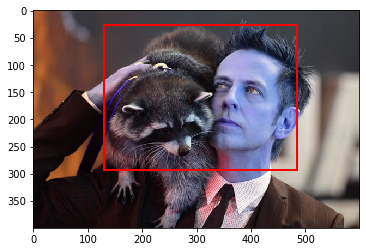

In [26]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [0]:
# Done at the top

#### Change your present working directory

In [0]:
# Done at the top

### Load your data file

In [0]:
daily_temp_df = pd.read_csv('daily-minimum-temperatures-in-me.csv', index_col='Date')

#### Plot data

In [0]:
daily_temp_df_original = daily_temp_df.copy(deep=True)

In [0]:
daily_temp_df['Date'] = pd.to_datetime(daily_temp_df['Date'], errors='coerce')

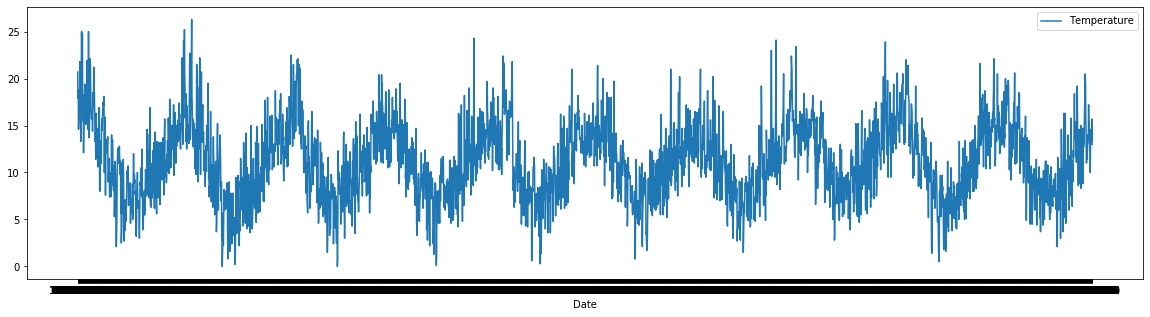

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
sns.lineplot(data=daily_temp_df)

#### Descibe your dataframe

In [59]:
daily_temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
Temperature    3650 non-null float64
dtypes: float64(1)
memory usage: 57.0+ KB


In [60]:
daily_temp_df.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [61]:
daily_temp_df.isna().sum()

Temperature    0
dtype: int64

#### Drop null values

In [0]:
daily_temp_df.dropna(axis=0, inplace=True)

#### Get the representation of the distribution of data in the form of histogram

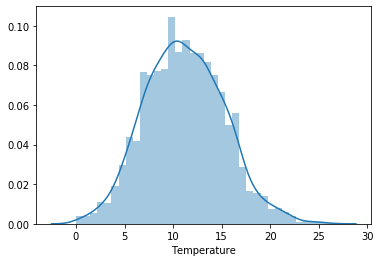

In [63]:
sns.distplot(daily_temp_df['Temperature'])

#### Check the maximum and minimum values

In [64]:
# Scaled Data
print('Min\n', np.min(daily_temp_df))
print('\nMax\n', np.max(daily_temp_df))

Min
 Temperature    0.0
dtype: float64

Max
 Temperature    26.3
dtype: float64


### Normalize the data

In [0]:
#convert datatype to float 
daily_temp_df = daily_temp_df.astype('float32')

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
#apply the sclaing to make values between 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(daily_temp_df)

#### Check the maximum and minimum values of scaled data

In [68]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


#### Look into some of the scaled values

In [69]:
print(scaled[:10])

[[0.7870723 ]
 [0.6806084 ]
 [0.7148289 ]
 [0.5551331 ]
 [0.6007605 ]
 [0.6007605 ]
 [0.6007605 ]
 [0.661597  ]
 [0.82889736]
 [0.7604563 ]]


### Split data into Training and Testing

In [0]:
#Split the data into train and test based on time
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]

#### Print train and test size

In [71]:
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]        
        dataX.append(a)        
        dataY.append(dataset[i + look_back, 0])        
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [0]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [74]:
len(X_train)

2554

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [75]:
#samples, time_steps, features
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2554, 1, 1)
(1094, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [0]:
from tensorflow.keras.layers import LSTM, Dense

In [0]:
#The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.
#create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


### Summarize your model

In [86]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [88]:
model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=1, shuffle=True)

Train on 2554 samples
Epoch 1/200
2554/2554 [==============================] - 7s 3ms/sample - loss: 0.0154
Epoch 2/200
2554/2554 [==============================] - 7s 3ms/sample - loss: 0.0105
Epoch 3/200
2554/2554 [==============================] - 7s 3ms/sample - loss: 0.0103
Epoch 4/200
2554/2554 [==============================] - 7s 3ms/sample - loss: 0.0103
Epoch 5/200
2554/2554 [==============================] - 7s 3ms/sample - loss: 0.0102
Epoch 6/200
2554/2554 [==============================] - 7s 3ms/sample - loss: 0.0103
Epoch 7/200
2554/2554 [==============================] - 7s 3ms/sample - loss: 0.0102
Epoch 8/200
2554/2554 [==============================] - 7s 3ms/sample - loss: 0.0103
Epoch 9/200
2554/2554 [==============================] - 7s 3ms/sample - loss: 0.0101
Epoch 10/200
2554/2554 [==============================] - 7s 3ms/sample - loss: 0.0103
Epoch 11/200
2554/2554 [==============================] - 7s 3ms/sample - loss: 0.0102
Epoch 12/200
2554/2554 [======

## Make Predictions and Evaluate your model

In [89]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.61 RMSE
Test Score: 2.44 RMSE


## Plot the results

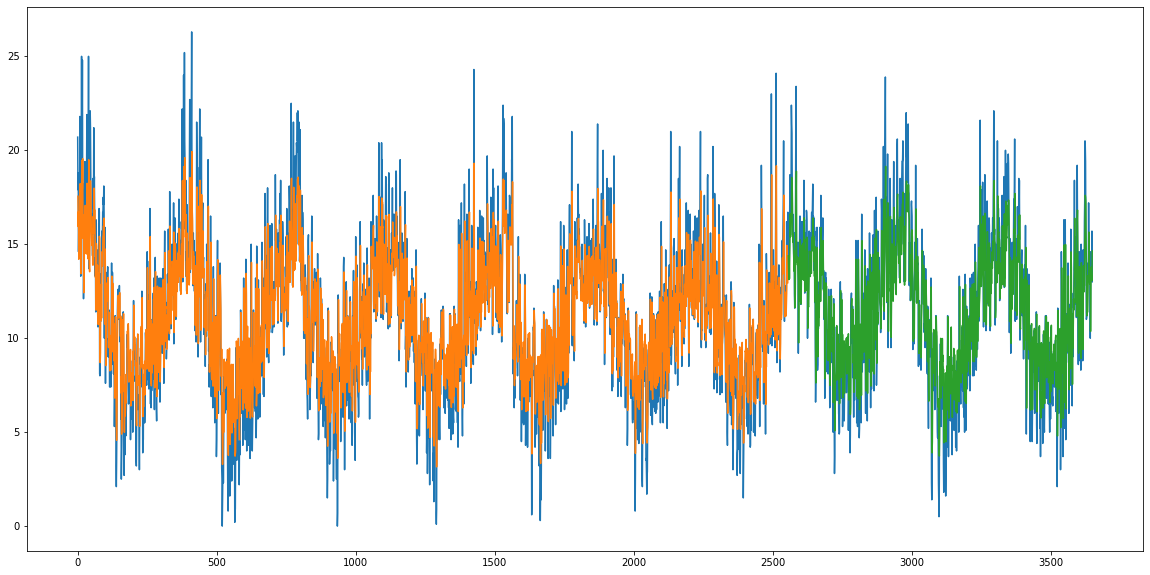

In [90]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(scaled), :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()